In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["CustomerID",'Churn_Label'], inplace = True, axis = 1)
    
    df.Total_Charges = df.Total_Charges.replace(" ",np.nan)
    df.Total_Charges.fillna(0, inplace = True)
    df.Total_Charges = df.Total_Charges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'Paperless_Billing', 'Phone_Service']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.Gender = df.Gender.apply(lambda x: 0 if x == "Male" else 1)
    df.Multiple_Lines = df.Multiple_Lines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['Senior_Citizen','Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['Internet_Service', 'Contract', 'Payment_Method'], drop_first=True)
    
    return df

In [4]:
df = datapreparation(filepath = "Telco_Customer_Churn_Survival_Analysis.csv")
df.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,...,Monthly_Charges,Total_Charges,Churn_Value,Internet_Service_Fiber optic,Internet_Service_No,Contract_One year,Contract_Two year,Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,1,0,1,0,9,1,0,0,1,0,...,65.6,593.30,0,0,0,1,0,0,0,1
1,0,0,0,0,9,1,1,0,0,0,...,59.9,542.40,0,0,0,0,0,0,0,1
2,0,0,0,0,4,1,0,0,0,1,...,73.9,280.85,1,1,0,0,0,0,1,0
3,0,1,1,0,13,1,0,0,1,1,...,98.0,1237.85,1,1,0,0,0,0,1,0
4,1,1,1,0,3,1,0,0,0,0,...,83.9,267.40,1,1,0,0,0,0,0,1


In [5]:
pd.isnull(df).sum()

Gender                                    0
Senior_Citizen                            0
Partner                                   0
Dependents                                0
Tenure_Months                             0
Phone_Service                             0
Multiple_Lines                            0
Online_Security                           0
Online_Backup                             0
Device_Protection                         0
Tech_Support                              0
Streaming_TV                              0
Streaming_Movies                          0
Paperless_Billing                         0
Monthly_Charges                           0
Total_Charges                             0
Churn_Value                               0
Internet_Service_Fiber optic              0
Internet_Service_No                       0
Contract_One year                         0
Contract_Two year                         0
Payment_Method_Credit card (automatic)    0
Payment_Method_Electronic check 

## Model Building

In [6]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import OrdinalEncoder
from sksurv.datasets import load_gbsg2
from sklearn.preprocessing import OneHotEncoder 
from lifelines import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

### Random Survival Forest Model

https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.ensemble.RandomSurvivalForest.html

In [7]:
y=df.loc[:, ["Churn_Value","Tenure_Months"]].to_numpy()
dt=dtype=[('Status', '?'), ('Tenure_in_months', '<f8')]
y=np.array([tuple(row) for row in y], dtype=dt)
x=df.drop(["Churn_Value","Tenure_Months"],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

valueError: y must be a structured array with the first field being a binary class event indicator and the second field the time of the event/censorin
https://stackoverflow.com/questions/68869020/valueerror-y-must-be-a-structured-array-with-the-first-field-being-a-binary-cla

#### Grid 1: Selecting max_features and estimators

In [ ]:
param_rsf_grid1 = {'max_features':['auto', 'sqrt', 'log2', None],
          'n_estimators':[300,500,700]
         }

rsf_model = RandomSurvivalForest()
rsf_grid1 = GridSearchCV(estimator=rsf_model, param_grid=param_rsf_grid1, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
rsf_grid1.fit(x_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
print(rsf_grid1.best_params_)

#### Grid 2: Selecting max_depth and estimators

In [ ]:
param_rsf_grid2 = {'max_features':['auto'],
          'n_estimators':[250, 300, 350],  
          'max_depth': [5, 7, 9]
         }

rsf_model = RandomSurvivalForest()
rsf_grid2 = GridSearchCV(estimator=rsf_model, param_grid=param_rsf_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
rsf_grid2.fit(x_train, y_train)

In [ ]:
print(rsf_grid2.best_params_)

#### Grid 3: Selecting max_depth, min_samples_leaf, min_samples_splitand estimators

In [ ]:
param_rsf_grid3 = {
        'max_features':['auto'],
          'n_estimators':[250],  
          'max_depth': [5],
        'min_samples_leaf': [ 3, 5, 7],
          'min_samples_split': [2, 4, 6]
         }

rsf_model = RandomSurvivalForest()
rsf_grid3 = GridSearchCV(estimator=rsf_model, param_grid=param_rsf_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
rsf_grid3.fit(x_train, y_train)

In [ ]:
print(rsf_grid3.best_params_)

In [8]:
rsf = RandomSurvivalForest(min_samples_leaf=3, min_samples_split=2,max_features='auto',max_depth=5,n_estimators=250, n_jobs=-1)

In [9]:
rsf.fit(x_train, y_train)

RandomSurvivalForest(max_depth=5, min_samples_split=2, n_estimators=250,
                     n_jobs=-1)

In [10]:
rsf.predict(x_test)

array([ 1.68181346, 93.66342686, 67.10783003, ..., 74.21802305,
       43.23332342,  3.27077844])

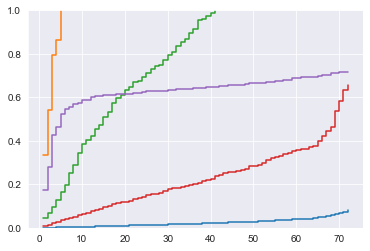

In [17]:
surv_funcs = rsf.predict_cumulative_hazard_function(x_test.iloc[:5])
for fn in surv_funcs:
   plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

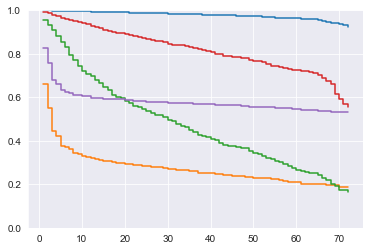

In [18]:
surv_funcs = rsf.predict_survival_function(x_test.iloc[:5])
for fn in surv_funcs:
   plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

In [13]:
rsf.score(x_train, y_train)

0.9208700750117865

In [14]:
rsf.score(x_test, y_test)

0.9026447192149171

In [15]:
rsf.score(x_test, y_test)

0.9026447192149171

In [16]:
perm = PermutationImportance(rsf, n_iter=35)
perm.fit(x_test, y_test)
eli5.show_weights(perm, feature_names=x.columns.tolist())

Weight,Feature
0.1292 ± 0.0095,Total_Charges
0.0383 ± 0.0079,Contract_Two year
0.0126 ± 0.0032,Contract_One year
0.0065 ± 0.0033,Internet_Service_Fiber optic
0.0054 ± 0.0031,Dependents
0.0033 ± 0.0019,Online_Backup
0.0023 ± 0.0021,Online_Security
0.0022 ± 0.0015,Partner
0.0010 ± 0.0002,Multiple_Lines
0.0005 ± 0.0006,Device_Protection
